In [ ]:
from huggingface_hub import login
login(new_session=False)

# workflow
......


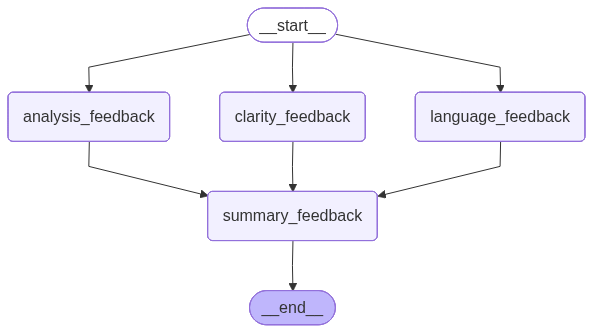

**Project Title: UPSC Essay Evaluation using LangGraph**

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load model + tokenizer once
tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-270m-it")
model = AutoModelForCausalLM.from_pretrained("google/gemma-3-270m-it")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Small helper so we can call model.invoke(prompt).content
class HFChatModel:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def invoke(self, prompt: str):
        messages = [
            {"role": "user", "content": prompt},
        ]
        inputs = self.tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt",
        ).to(self.device)

        outputs = self.model.generate(**inputs, max_new_tokens=300)
        text = self.tokenizer.decode(
            outputs[0][inputs["input_ids"].shape[-1]:],
            skip_special_tokens=True,
        )
        return type("Response", (), {"content": text.strip()})

# Wrap the huggingface model so it feels like your original one
chat_model = HFChatModel(model, tokenizer, device)


In [ ]:
import re
import json
from pydantic import BaseModel, Field, ValidationError

class EvaluateS(BaseModel):
    feedback: str = Field(description='Detailed feedback on essay')
    score: float = Field(description='Score out of 10', ge=0, le=10)

class StructuredModel:
    def __init__(self, chat_model, schema: type[BaseModel]):
        self.chat_model = chat_model
        self.schema = schema

    def invoke(self, prompt: str):
        structured_prompt = (
            f"{prompt}\n\nRespond ONLY in JSON format with these fields:\n"
            f"- feedback (string): detailed feedback on the essay\n"
            f"- score (float, 0-10): score out of 10"
        )

        response = self.chat_model.invoke(structured_prompt).content

        # Extract the JSON object from the response
        match = re.search(r"({.*})", response, flags=re.DOTALL)
        if match:
            json_text = match.group(1)
            try:
                data = json.loads(json_text)
            except json.JSONDecodeError:
                data = {"feedback": response, "score": 0.0}
        else:
            data = {"feedback": response, "score": 0.0}

        # Ensure keys exist
        if "feedback" not in data:
            data["feedback"] = response
        if "score" not in data:
            # Try to extract score from feedback text
            score_match = re.search(r"(\d+(\.\d+)?)\s*(?:out of 10)?", data["feedback"])
            if score_match:
                data["score"] = float(score_match.group(1))
            else:
                data["score"] = 0.0

        # Validate using Pydantic
        try:
            validated = self.schema(**data)
        except ValidationError:
            validated = self.schema(feedback=data.get("feedback", ""), score=data.get("score", 0.0))

        return validated


In [ ]:
essay = """India in the Age of AI
As the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.

India's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for All) with a focus on inclusive growth, aiming to leverage AI in healthcare, agriculture, education, and smart mobility.

One of the most promising applications of AI in India lies in agriculture, where predictive analytics can guide farmers on optimal sowing times, weather forecasts, and pest control. In healthcare, AI-powered diagnostics can help address India’s doctor-patient ratio crisis, particularly in rural areas. Educational platforms are increasingly using AI to personalize learning paths, while smart governance tools are helping improve public service delivery and fraud detection.

However, the path to AI-led growth is riddled with challenges. Chief among them is the digital divide. While metropolitan cities may embrace AI-driven solutions, rural India continues to struggle with basic internet access and digital literacy. The risk of job displacement due to automation also looms large, especially for low-skilled workers. Without effective skilling and re-skilling programs, AI could exacerbate existing socio-economic inequalities.

Another pressing concern is data privacy and ethics. As AI systems rely heavily on vast datasets, ensuring that personal data is used transparently and responsibly becomes vital. India is still shaping its data protection laws, and in the absence of a strong regulatory framework, AI systems may risk misuse or bias.

To harness AI responsibly, India must adopt a multi-stakeholder approach involving the government, academia, industry, and civil society. Policies should promote open datasets, encourage responsible innovation, and ensure ethical AI practices. There is also a need for international collaboration, particularly with countries leading in AI research, to gain strategic advantage and ensure interoperability in global systems.

India’s demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth, improve governance, and uplift marginalized communities. But this vision will only materialize if AI is seen not merely as a tool for automation, but as an enabler of human-centered development.

In conclusion, India in the age of AI is a story in the making — one of opportunity, responsibility, and transformation. The decisions we make today will not just determine India’s AI trajectory, but also its future as an inclusive, equitable, and innovation-driven society."""

In [ ]:
prompt = f"""
Evaluate the clarity of thought in the following essay.
Provide detailed feedback and assign a score out of 10.

Essay:
{essay}
"""
structured_model = StructuredModel(chat_model, EvaluateS)
result = structured_model.invoke(prompt)

print("Feedback:", result.feedback)
print("Score:", result.score)

In [ ]:
result.score

In [ ]:
import operator
from typing import TypedDict, Annotated

class UPSCScores(TypedDict):
    essay: str
    language_feedback: str
    clarity_feedback: str
    analysis_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[float], operator.add]
    average_score: float


In [ ]:
def language_feedback(state: UPSCScores) -> UPSCScores:
    essay = state['essay']

    prompt = f"Evaluate the language quality of the following essay and provide feedback and assign a score out of 10:\n{essay}"

    structured_model = StructuredModel(chat_model, EvaluateS)
    result = structured_model.invoke(prompt)

    language_feedback = result.feedback
    individual_scores = [result.score]

    return {'language_feedback': language_feedback, 'individual_scores': individual_scores}


In [ ]:
def clarity_feedback(state: UPSCScores) -> UPSCScores:
    essay = state['essay']

    prompt = f"""Evaluate the clarity of thought in the following essay. Provide detailed feedback and assign a score out of 10. Essay: {essay}"""

    structured_model = StructuredModel(chat_model, EvaluateS)
    result = structured_model.invoke(prompt)

    clarity_feedback = result.feedback
    individual_scores = [result.score]

    return {'clarity_feedback': clarity_feedback, 'individual_scores': individual_scores}


In [ ]:
def analysis_feedback(state: UPSCScores) -> UPSCScores:
    essay = state['essay']

    prompt = f"""Evaluate the depth of analysis in the following essay. Provide detailed feedback and assign a score out of 10. Essay:{essay}"""

    structured_model = StructuredModel(chat_model, EvaluateS)
    result = structured_model.invoke(prompt)

    analysis_feedback = result.feedback
    individual_scores = [result.score]

    return {'analysis_feedback': analysis_feedback, 'individual_scores': individual_scores}


In [ ]:
def summary_feedback(state: UPSCScores) -> UPSCScores:
    prompt = f"""Based on the following feedbacks, create a summarized feedback:
    Language feedback - {state['language_feedback']}
    Depth of analysis feedback - {state['analysis_feedback']}
    Clarity of thought feedback - {state['clarity_feedback']}"""

    result = chat_model.invoke(prompt).content

    average_score = sum(state['individual_scores']) / len(state['individual_scores'])

    return {'overall_feedback': result, 'average_score': average_score}


In [ ]:
graph = StateGraph(UPSCScores)
graph.add_node('language_feedback', language_feedback)
graph.add_node('clarity_feedback', clarity_feedback)
graph.add_node('analysis_feedback', analysis_feedback)
graph.add_node('summary_feedback', summary_feedback)

graph.add_edge(START, 'language_feedback')
graph.add_edge(START, 'clarity_feedback')
graph.add_edge(START, 'analysis_feedback')
graph.add_edge('language_feedback', 'summary_feedback')
graph.add_edge('clarity_feedback', 'summary_feedback')
graph.add_edge('analysis_feedback', 'summary_feedback')
graph.add_edge('summary_feedback', END)

workflow = graph.compile()


In [ ]:
workflow

In [ ]:
essay = """India in the Age of AI
As the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.

India's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for All) with a focus on inclusive growth, aiming to leverage AI in healthcare, agriculture, education, and smart mobility.

One of the most promising applications of AI in India lies in agriculture, where predictive analytics can guide farmers on optimal sowing times, weather forecasts, and pest control. In healthcare, AI-powered diagnostics can help address India’s doctor-patient ratio crisis, particularly in rural areas. Educational platforms are increasingly using AI to personalize learning paths, while smart governance tools are helping improve public service delivery and fraud detection.

However, the path to AI-led growth is riddled with challenges. Chief among them is the digital divide. While metropolitan cities may embrace AI-driven solutions, rural India continues to struggle with basic internet access and digital literacy. The risk of job displacement due to automation also looms large, especially for low-skilled workers. Without effective skilling and re-skilling programs, AI could exacerbate existing socio-economic inequalities.

Another pressing concern is data privacy and ethics. As AI systems rely heavily on vast datasets, ensuring that personal data is used transparently and responsibly becomes vital. India is still shaping its data protection laws, and in the absence of a strong regulatory framework, AI systems may risk misuse or bias.

To harness AI responsibly, India must adopt a multi-stakeholder approach involving the government, academia, industry, and civil society. Policies should promote open datasets, encourage responsible innovation, and ensure ethical AI practices. There is also a need for international collaboration, particularly with countries leading in AI research, to gain strategic advantage and ensure interoperability in global systems.

India’s demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth, improve governance, and uplift marginalized communities. But this vision will only materialize if AI is seen not merely as a tool for automation, but as an enabler of human-centered development.

In conclusion, India in the age of AI is a story in the making — one of opportunity, responsibility, and transformation. The decisions we make today will not just determine India’s AI trajectory, but also its future as an inclusive, equitable, and innovation-driven society."""

In [ ]:
initial_state = {'essay': essay}

In [ ]:
final_state = workflow.invoke(initial_state)

In [ ]:
print(final_state['language_feedback'])
